<a href="https://colab.research.google.com/github/jonDuke/GAN_training/blob/main/CIFAR10/GAN_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to set up a GAN to generate images

This notebook is following a tutorial on how to set up a GAN (Generative Adversarial Network) that generates new random photos.  It will be trained on the CIFAR10 image set, which was originally intended to be an image classification dataset.

It follows this tutorial: https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/

## Loading the training images

First off we load the image set we will be training our neural net on.  The CIFAR10 set is already available through Keras.

In [1]:
from keras.datasets.cifar10 import load_data

# Load the images into memory.  We are only actually using the training images
(trainX, _), (_, _) = load_data()

# Summarize the shape of the dataset
# There should be 50,000 images in this set, all size 32x32 with 3 color channels per pixel
print('Train images:', trainX.shape)

170500096/170498071 [==============================] - 4s 0us/step
Train images: (50000, 32, 32, 3)


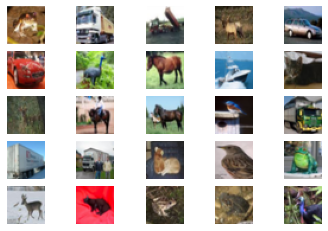

In [2]:
# This cell displays a random set of 25 images
from matplotlib import pyplot

# plot images from the training dataset
for i in range(25):
	# define subplot
	pyplot.subplot(5, 5, 1 + i)
	# turn off axis
	pyplot.axis('off')
	# plot raw pixel data
	pyplot.imshow(trainX[i])

pyplot.show()

As you can see, the image set consists of thousands of small pictures of various objects and animals.  All images are 32x32 pixels.

# Setting up the models

GAN's have "adversarial" in their names because they work by pitting two models against each other: a discriminator and a generator.  The generator takes a set of random numbers as input and turns that into a randomly generated image.  The discriminator is a binary classification model that decides if an image is real or fake.

By pitting these two models against each other, the generator will get better and better at making fake images that fool the discriminator into thinking they are real.

## The discriminator model

First we will set up and train the discriminator model.  This one actually trains very fast with this image set.

In [3]:
# imports used in the discriminator model section
from numpy import expand_dims, ones, zeros
from numpy.random import rand, randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, LeakyReLU

First up we define the model structure.  First we define the input shape to match the shape of the image data (32, 32, 3).  The first convolution layer simply does normal convolution, while the following three use the stride of (2,2) to downsample by half each time.  The final layers flatten into a single dimension and output a single number using the sigmoid function, which gives us a probability between 0 and 1 of if the picture is judged to be real or not.

The tutorial itself goes much more in-depth to explain this structure if you want to know more, I will simply be summarizing in this notebook.

In [4]:
# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [5]:
# Model summary
define_discriminator().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         2

Next up we define functions that load the data, perform some pre-processing, and return a batch of them for the model to use.

The original picture data has each color channel represented as an integer between 0 and 255, but we want a range between -1 and 1 since that is how the generator will output its random images.  The first function converts all image data to that format for us.

The second one simply returns `n_samples` random images from the given dataset.  We will use this to generate our batches.

In [6]:
# load and prepare cifar10 training images
def load_real_samples():
	# load cifar10 dataset
	(trainX, _), (_, _) = load_data()
	# convert from unsigned ints to floats
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

So we have a function to get us real pictures, but the model will also need fake ones to learn with.  Since we don't have a generator just yet, we can get fake images by simply generating a bunch of images with completely random data.  If displayed, these would basically look like colorful static.

In [7]:
# generate n fake samples with class labels
def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	X = rand(32 * 32 * 3 * n_samples)
	# update to have the range [-1, 1]
	X = -1 + X * 2
	# reshape into a batch of color images
	X = X.reshape((n_samples, 32, 32, 3))
	# generate 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

And finally we set up the code to train the discriminator model.  This is also wrapped in a function, to make using it very simple.

By default, it is set to run for only 20 iterations, with a batch size of 128.  

In [8]:
# train the discriminator model
def train_discriminator(model, dataset, n_iter=20, n_batch=128):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [9]:
# These couple lines create the model and train it, using all the functions defined above

# define the discriminator model
d_model = define_discriminator()
# load image data
dataset = load_real_samples()
# fit the model
train_discriminator(d_model, dataset)

>1 real=78% fake=0%
>2 real=97% fake=0%
>3 real=100% fake=12%
>4 real=98% fake=28%
>5 real=92% fake=70%
>6 real=95% fake=95%
>7 real=92% fake=100%
>8 real=98% fake=100%
>9 real=98% fake=100%
>10 real=94% fake=100%
>11 real=94% fake=100%
>12 real=97% fake=100%
>13 real=100% fake=100%
>14 real=98% fake=100%
>15 real=98% fake=100%
>16 real=98% fake=100%
>17 real=100% fake=100%
>18 real=100% fake=100%
>19 real=100% fake=100%
>20 real=100% fake=100%


Like I said, the model trains very fast with this dataset.  It is able to correctly classify fake images after only a few epochs, and real ones in under 20.  This is largely because the images are so simple: 32x32 pixels isn't exacly high definition.

## The generator model

The generator model will work a lot like the discriminator does, just in reverse.  We also won't be doing any training in this section, that comes later.

In [10]:
# Inputs used in the generator model section
from numpy import zeros
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense, Reshape, Conv2D, Conv2DTranspose, LeakyReLU
from matplotlib import pyplot

The generator model is set up to take an arbitrary amount of random numbers as input.  We end up using 100 in this example, but other numbers can work just as well.

First it sets up a Dense layer with 4096 nodes (256 * 4 * 4), representing a 4x4 image.  It then uses a series of Conv2DTranspose layers to upscale, each multiplying the size by 2 until we have a 32x32 array.  The last step uses a Conv2D layer and outputs the 32x32x3 shape that matches our image format.  It also uses a tanh activation to ensure outputs are all in a range of [-1,1].

Again, the original tutorial goes more in-depth on why these are chosen.

In [11]:
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	# upsample to 8x8
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

In [12]:
# Model summary
define_generator(100).summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 16, 16, 128)      

This next function generates a list of random numbers with gaussian distribution, a.k.a. the latent space which the generator takes as an input.

In [13]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

Next we redefine the `generate_fake_samples()` function to make use of the generator model instead of just outputting random noise.

In [14]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

Even though the generator model isn't trained yet, we can still tell it to output some images to make sure everything runs.  Since it is not trained, the "random" images all turn out grey.

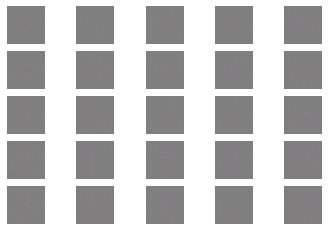

In [15]:
# size of the latent space
latent_dim = 100
# define the discriminator model
g_model = define_generator(latent_dim)
# generate samples
n_samples = 25
X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
# scale pixel values from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the generated samples
for i in range(n_samples):
	# define subplot
	pyplot.subplot(5, 5, 1 + i)
	# turn off axis labels
	pyplot.axis('off')
	# plot single image
	pyplot.imshow(X[i])
# show the figure
pyplot.show()

# Putting it all together and training the generator

Now we have our two models, we can set up the GAN itself.  To define it, we create another model that uses the two we built already.  We also disable training on the discriminator so that we only train one side of the model at a time.

In [16]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

Evaluating the performance of a GAN is difficult, so we use these next functions to periodically save the model weights and an example of their outputs.  These will get called in the training function next.

In [20]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)

Here we build the function that will do all the actual training.  It manually iterates through epochs and batches, calculating loss for both the discriminator and generator separately at each batch.

I have added one modification, a check to only print the summary line once every 10 batches.  With the current parameters, every epoch trains for 390 batches, resulting in 78,000 individual batches being run.

Additionally, it calls the summary function from the cell above every 10 epochs in order to save model checkpoints.  These save example images that can be viewed and judged by humans to see how good the GAN has gotten at generating images.

In [39]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch (every 10 batches)
            if j%10==0:
                print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                    (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        # evaluate the model performance, sometimes
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

Next we define the latent dimension, generate models using the functions we created earlier, and put the GAN itself together.

Then in the next cell, we train the GAN itself.  This performs much faster on GPU, but will take a lot of time even then.

In [40]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_11 (Sequential)   (None, 32, 32, 3)         1466115   
_________________________________________________________________
sequential_10 (Sequential)   (None, 1)                 522497    
Total params: 1,988,612
Trainable params: 1,466,115
Non-trainable params: 522,497
_________________________________________________________________


In [41]:
%%time
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

[redacted, we don't need thousands of lines of this on github]
...
>200, 301/390, d1=0.543, d2=0.522 g=1.466
>200, 311/390, d1=0.510, d2=0.400 g=1.388
>200, 321/390, d1=0.573, d2=0.520 g=1.393
>200, 331/390, d1=0.505, d2=0.441 g=1.323
>200, 341/390, d1=0.509, d2=0.453 g=1.269
>200, 351/390, d1=0.470, d2=0.598 g=1.528
>200, 361/390, d1=0.536, d2=0.404 g=1.506
>200, 371/390, d1=0.467, d2=0.559 g=1.225
>200, 381/390, d1=0.685, d2=0.557 g=1.230
>Accuracy real: 73%, fake: 85%
CPU times: user 1h 13min 24s, sys: 6min 57s, total: 1h 20min 21s
Wall time: 2h 16min 59s


# Saving data

This took a couple hours to train on Colab's GPU instance, so I don't want the data to just disappear.  This code cell automatically downloads all of the .png preveiws and .h5 models that were saved during training.  I can set it to run automatically after the model has finished training so I won't have to worry about the session timing out when I'm not looking.

In [42]:
import os
from google.colab import files
from zipfile import ZipFile

# find all .png and .h5 files in the current directory
fnames = [f for f in os.listdir('.') if f.endswith('.png') or f.endswith('.h5')]

# start a zip object and write all found files to it
zipObj = ZipFile('GAN_data.zip', 'w')
for f in fnames:
    zipObj.write(f)

# close the zip file and download it to my local machine
zipObj.close()
files.download('GAN_data.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Final results

So we trained for all that time!  Let's see what we got from it.

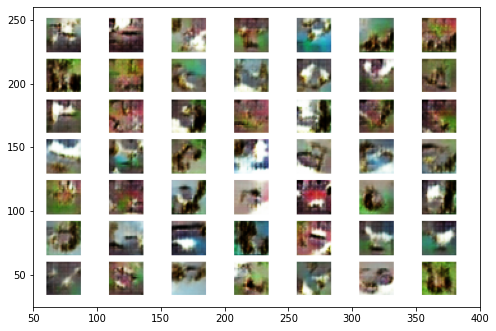

In [53]:
# Just for demonstration, here's the first checkpoint after only 10 epochs
from matplotlib import image
from matplotlib import pyplot as plt

def plot_image(fname):
    # load image and display it
    data = image.imread(fname)
    plt.figure(figsize=(8,6))
    plt.xlim(50, 400)
    plt.ylim(25, 260)
    plt.imshow(data)
    plt.show()

plot_image('generated_plot_e010.png')

As you can see, the images generated this early are just colorful blobs.  But that's a lot better than random static or flat gray!  Now halfway through, after 100 epochs:

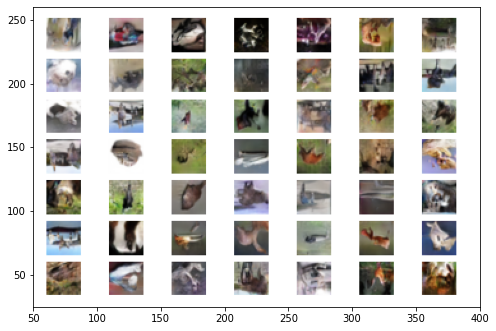

In [54]:
plot_image('generated_plot_e100.png')

Images are starting to become more distinct.  You can see more defined shapes in these, but it's still kinda obvious to us they are fake.  At the end, after 200 epochs though:

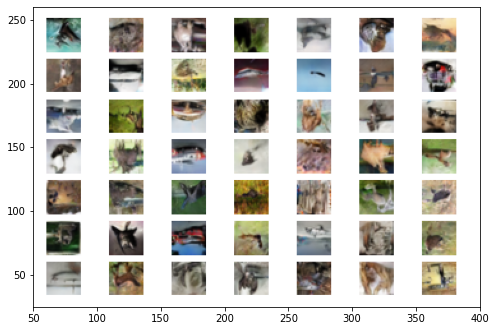

In [55]:
plot_image('generated_plot_e200.png')

Well, they're still not that realistic to our eyes, but they're looking pretty good for a model that only took 2 hours to train!

And what notebook would be complete without a demonstration of the final product?  This code cell will load the last model saved and generate some new images.  It can, of course, work with any .h5 model so this can be run after loading old files instead of having to train a brand new model for 2 hours.

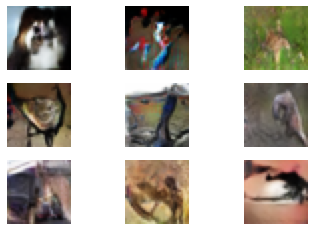

In [67]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot as plt
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# plot the generated images
def create_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :])
    plt.show()

# load specified model
model = load_model('generator_model_200.h5')
# generate images
latent_points = generate_latent_points(100, 9)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 3)

# Conclusion

"These images are terrible!  Anyone could see they're fake!"

Well yeah, this was a beginner project done over the course of a few hours.  One thing that comes to mind is that we threw in pictures of 10 different things all at once.  If we separated them, maybe trained only on pictures of horses or cars or something, the image quality would probably go up.  I think I'll come back and do that later, but this is good for today.

I might also modify the training code to generate bigger examples so you can see them better, those were kinda tiny I know.

What this did show is that it's not too hard to start training a GAN when the architecture is set up for you.  Big thanks to Jason Brownlee who wrote the tutorial this followed!

(here's the link again if you don't want to scroll to the top: https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/ )